In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


In [ ]:
# 1. Keras에서 MNIST 데이터 로드
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 데이터 전처리
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
train_images = np.expand_dims(train_images, axis=-1)  # 채널 차원 추가
test_images = np.expand_dims(test_images, axis=-1)

# NumPy 배열을 PyTorch 텐서로 변환
train_images_tensor = torch.FloatTensor(train_images.transpose(0, 3, 1, 2))  # (N, C, H, W) 형식으로
train_labels_tensor = torch.LongTensor(train_labels)
test_images_tensor = torch.FloatTensor(test_images.transpose(0, 3, 1, 2))
test_labels_tensor = torch.LongTensor(test_labels)

# DataLoader 생성
batch_size = 128
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class KerasLikeCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(KerasLikeCNN, self).__init__()

        # 첫 번째 컨볼루션 블록
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # 두 번째 컨볼루션 블록
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # 세 번째 컨볼루션 블록
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # 완전 연결 층
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*3*3, 256),  # MaxPool 3번 적용 후 크기: 28 -> 14 -> 7 -> 3 (3.5는 내림)
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # L2 정규화를 위한 옵티마이저 파라미터
        self.l2_lambda = 0.001

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x

    # L2 정규화 계산 (Keras의 kernel_regularizer=l2(0.001) 구현)
    def l2_regularization(self):
        l2_reg = torch.tensor(0.).to(device)
        for param in self.parameters():
            l2_reg += torch.norm(param, p=2)
        return self.l2_lambda * l2_reg


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KerasLikeCNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) + model.l2_regularization()  # L2 정규화 추가
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = train_loss / len(train_loader)

    print(f'Train Epoch: {epoch} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [ ]:
#테스트 함수
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)

    print(f'Test set: Average loss: {avg_loss:.4f}, Accuracy: {correct}/{total} ({accuracy:.2f}%)')
    return avg_loss, accuracy


In [ ]:
'''
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

'''

from copy import deepcopy

# 최고 성능 모델 저장을 위한 변수 초기화
best_accuracy = 0.0
best_model_state = None

epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # 최고 정확도 모델 저장
    if test_acc > best_accuracy:
        print(f'Test accuracy improved from {best_accuracy:.2f}% to {test_acc:.2f}%. Saving model...')
        best_accuracy = test_acc
        best_model_state = deepcopy(model.state_dict())

        # 모델 저장 (Google Colab에서는 Google Drive에 저장하는 것이 좋음)
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_loss': train_loss,
            'test_loss': test_loss,
        }, 'best_model.pth')

# 훈련 종료 후 최고 성능 모델로 복원
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f'\nLoaded best model with test accuracy: {best_accuracy:.2f}%')

# 최종 평가
final_test_loss, final_test_acc = test(model, device, test_loader, criterion)
print(f'\nFinal Model - Test Accuracy: {final_test_acc:.2f}% | Test Loss: {final_test_loss:.4f}')

Train Epoch: 1 | Loss: 0.4220 | Accuracy: 92.44%
Test set: Average loss: 0.0361, Accuracy: 9889/10000 (98.89%)
Test accuracy improved from 0.00% to 98.89%. Saving model...
Train Epoch: 2 | Loss: 0.2081 | Accuracy: 98.05%
Test set: Average loss: 0.0314, Accuracy: 9903/10000 (99.03%)
Test accuracy improved from 98.89% to 99.03%. Saving model...
Train Epoch: 3 | Loss: 0.1941 | Accuracy: 98.49%
Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)
Test accuracy improved from 99.03% to 99.33%. Saving model...
Train Epoch: 4 | Loss: 0.1871 | Accuracy: 98.67%
Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)
Train Epoch: 5 | Loss: 0.1828 | Accuracy: 98.80%
Test set: Average loss: 0.0219, Accuracy: 9938/10000 (99.38%)
Test accuracy improved from 99.33% to 99.38%. Saving model...
Train Epoch: 6 | Loss: 0.1806 | Accuracy: 98.91%
Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)
Train Epoch: 7 | Loss: 0.1794 | Accuracy: 98.87%
Test set: Average loss: 0.0196, Accura

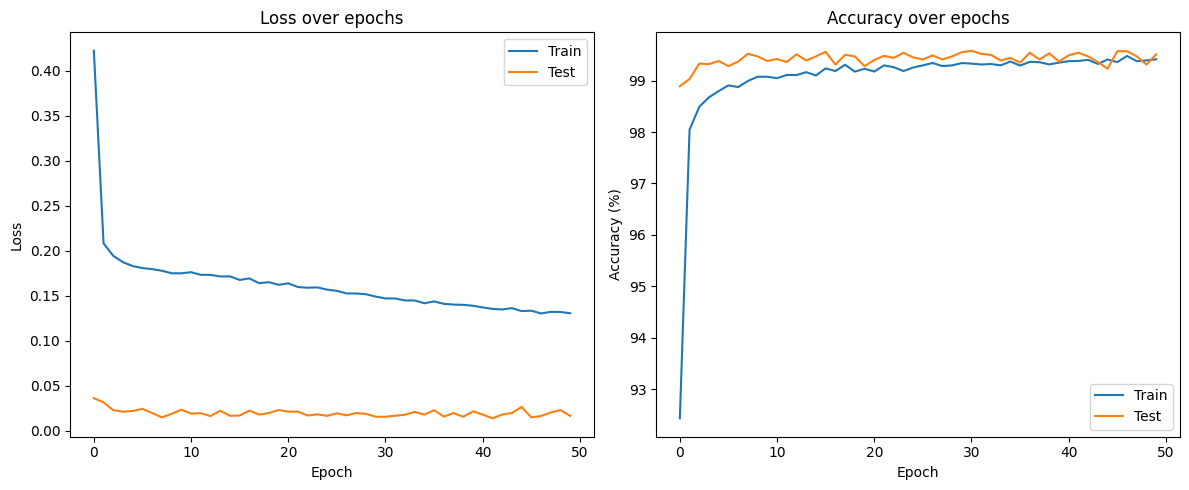

In [ ]:

#  결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#TEST데이터 정확도
model.eval()

correct = 0
total = 0

with torch.no_grad():  # 그래디언트 계산 비활성화
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 99.58%
